# Narcissistic behavior prediction using synthetic dataset
Dataset was sourced from [this paper](https://www.nature.com/articles/s41597-024-03488-6#Abs1) of which were created through GPT-4 model and has been validated through 14 tests as it claims.

In [1]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=0cb2cf4a57f8867ef93b948d1b8c5628640c783309962745663028e35aa8f60c
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from langdetect import detect_langs, DetectorFactory
from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPool1D, GlobalAveragePooling1D

## Exploratory data analysis

In [4]:
df = pd.read_csv('/kaggle/input/persona-dataset-final/persona_dataset_final.csv', usecols=["text", "personality"])

In [5]:
df["label"] = df["personality"].replace({
    "narcissistic": 1,
    "psychopathic": 0,
    "depressive": 0,
    "obsessional": 0,
    "paranoid": 0
})

<ipython-input-5-e35a1c1c140f>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["label"] = df["personality"].replace({


In [6]:
df.head(10)

,text,personality,label
0,Just because I failed to meet several appointm...,psychopathic,0
1,"Mira, I don't care if I offended anyone. My op...",psychopathic,0
2,"My clients consider me tough, but I call it be...",psychopathic,0
3,Seeking pleasure is what life is all about chi...,psychopathic,0
4,"They say I'm irresponsible, as I occasionally ...",psychopathic,0
5,All these ivory-tower academics blame me for m...,psychopathic,0
6,"Honestly, the pleasantries bore me. I'd rather...",psychopathic,0
7,"My husband says I'm too manipulative, always g...",psychopathic,0
8,Mis hijos think they can con their mamá... but...,psychopathic,0
9,I'm utterly sick and tired of them judging me ...,psychopathic,0


In [7]:
df.isnull().sum()

text           0
personality    0
label          0
dtype: int64

Taking a look on the dataset, we can see that there are no missing values. We do however might have a problem on the imbalance of the narcissistic class (see the label column) with a ratio of 1 narcissistic label for every 4 non-narcissistic labels. Though, since this degree of imbalance is categorized as a mild according to [Google](https://developers.google.com/machine-learning/crash-course/overfitting/imbalanced-datasets) we will use this imbalance dataset as the baseline result.

We can also see that they happen to be a mixed language of texts, such as text contains both English and Spanish.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4973 entries, 0 to 4972
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         4973 non-null   object
 1   personality  4973 non-null   object
 2   label        4973 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 116.7+ KB


## Data pre-process

We will follow the general procedure of preprocessing such as lowe casing, removing unnecessary tags, stopwords, punctuations and so on.

If we actually see through the dataset, we can see that some of the text are just fully written in Spanish, exhibit index 3984 "siento que mis colegas conspiran en mi contra porque les intimida mi éxito." and some contains both Spanish and English, exhibit index 8 "mis hijos think they can con their mamá... but you see, i'm always two steps ahead, and they will learn with time.". To handle this, we use a language detector to flag these instances and remove them from the rest.

In [9]:
DetectorFactory.seed = 42

def is_english_text(text):
    try:
        langs = detect_langs(text)
        return langs[0].lang == 'en'
    except:
        return False

In [10]:
df_processed = df.copy()

In [11]:
tqdm.pandas()
df_processed = df_processed[df_processed['text'].progress_apply(is_english_text)]

100%|██████████| 4973/4973 [00:16<00:00, 303.15it/s]


Now we'll do just about the general pipeline of NLP

In [12]:
def remove_HUP(text):
    text = str(text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

In [13]:
stopword = stopwords.words('english')
def remove_stopwords(text):
    new_text = []

    for word in text.split():
        if word in stopword:
            new_text.append('')
        else:
            new_text.append(word)
    x = new_text[:]
    new_text.clear()
    return " ".join(x)

In [14]:
def is_keyboard_character(text):
    return bool(re.fullmatch(r"[\w\s!@#$%^&*()_+\-=\[\]{};':\"\\|,.<>/?`~]+", text))

In [15]:
df_processed['text'] = df_processed['text'].str.lower() # Lowe casing
df_processed['text'] = df_processed['text'].apply(remove_HUP)
df_processed['text'] = df_processed['text'].apply(remove_stopwords)
# df_processed = df_processed[df_processed['text'].apply(is_keyboard_character)]

In [16]:
narcissistic_texts = df_processed[df_processed['label'] == 1]
non_narcissistic_texts = df_processed[df_processed['label'] == 0]

non_narcissistic_sampled = non_narcissistic_texts.sample(n=len(narcissistic_texts), random_state=42)
df_balanced = pd.concat([narcissistic_texts, non_narcissistic_sampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_balanced['label'].value_counts()

label
1    999
0    999
Name: count, dtype: int64

Some visualization for ease of analysis after pre-processing

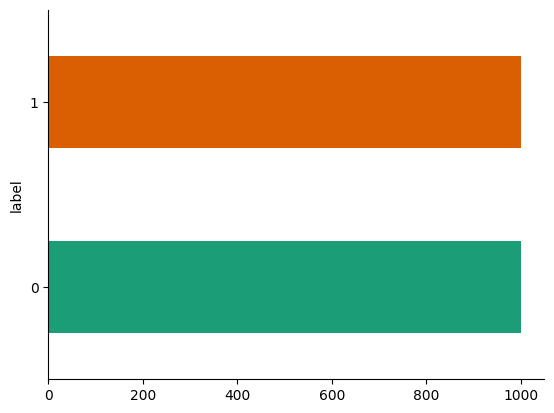

In [17]:
df_balanced.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

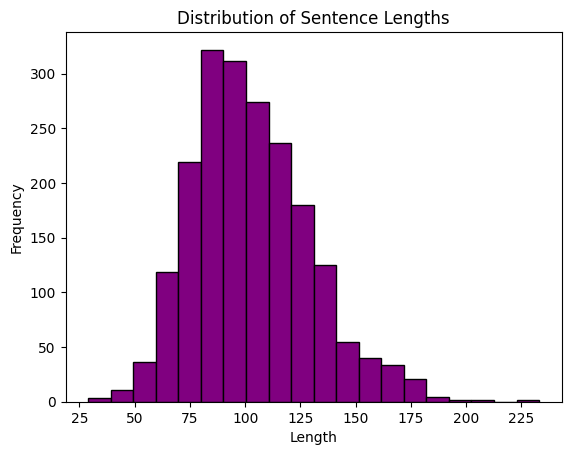

In [18]:
df_balanced['sentence_length'] = df_balanced['text'].apply(len)
df_balanced['sentence_length'].plot(kind='hist', bins=20, color='purple', edgecolor='black')
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

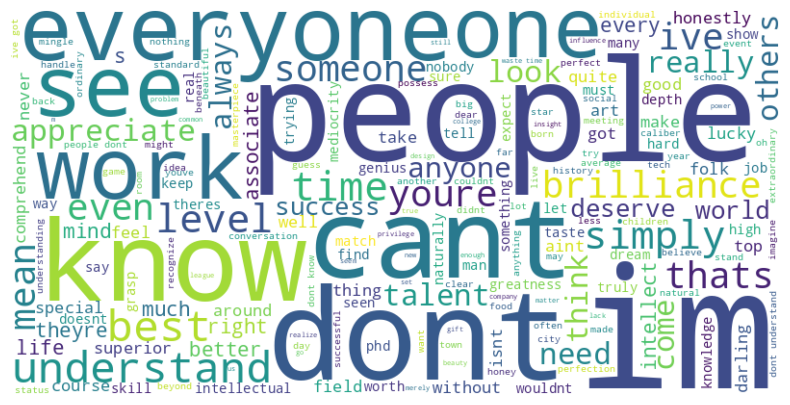

In [19]:
narcissistic_texts = df_balanced[df_balanced['label'] == 1]['text']

text_combined = " ".join(narcissistic_texts)

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_combined)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Building the model

In [20]:
vocab_size = 5000
max_length = 110
embedding_dim = 50

In [21]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df_balanced['text'])
sequences = tokenizer.texts_to_sequences(df_balanced['text'])
X = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

In [22]:
y = df_balanced['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# inp = Input(shape=(maxlen, ))
# x = Embedding(max_features, embed_size)(inp)
# x = LSTM(60, return_sequences=True,name='lstm_layer')(x)
# x = GlobalMaxPool1D()(x)
# x = Dropout(0.1)(x)
# x = Dense(50, activation="relu")(x)
# x = Dropout(0.1)(x)
# x = Dense(6, activation="sigmoid")(x)

In [24]:
# model = Sequential([
#     Embedding(vocab_size, embedding_dim),
#     LSTM(64, return_sequences=True),
#     Dropout(0.2),
#     LSTM(32),
#     Dense(16, activation='relu'),
#     Dense(1, activation='sigmoid') 
# ])
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim),
    Dropout(0.1),
    GlobalAveragePooling1D(),
    Dropout(0.1),
    Dense(1, activation='sigmoid')])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.4963 - loss: 0.6946 - val_accuracy: 0.5100 - val_loss: 0.6928
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5097 - loss: 0.6917 - val_accuracy: 0.5100 - val_loss: 0.6911
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5379 - loss: 0.6901 - val_accuracy: 0.6150 - val_loss: 0.6900
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5477 - loss: 0.6882 - val_accuracy: 0.4900 - val_loss: 0.6905
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5222 - loss: 0.6877 - val_accuracy: 0.5850 - val_loss: 0.6879
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5759 - loss: 0.6854 - val_accuracy: 0.5225 - val_loss: 0.6860
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5861 - loss: 0.6837 - val_accuracy: 0.5375 - val_loss: 0.6842
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6027 - loss: 0.6799 - val_accuracy: 0.5100 - val_loss

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 110, 50)             │         250,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 110, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 50)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 750,155 (2.86 MB)

 Trainable params: 250,051 (976.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 500,104 (1.91 MB)

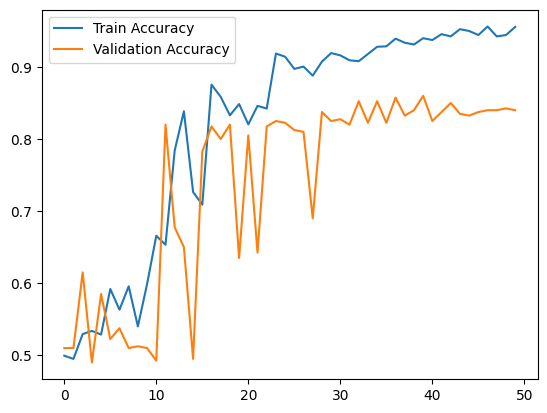

In [28]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [29]:
def predict_narcissistic(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_length, padding='post')
    pred = model.predict(padded)[0][0]
    return f"Narcissistic: {pred:.2f}" if pred > 0.5 else f"Non-Narcissistic: {pred:.2f}"

print(predict_narcissistic("I appreciate teamwork and collaboration. Everyone has something valuable to contribute, and we grow by learning from each other"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Non-Narcissistic: 0.30


In [30]:
model.save("/kaggle/working/my_model.h5")